#Perfoming Logistic Regression on Poems from poetryfoundation.org

Data Source: https://www.kaggle.com/ultrajack/modern-renaissance-poetry

Poems from poetryfoundation.org dataset consists of poems from different genres.

Number of poems : 573

Number of Attributes/Columns in data : 5

###Attribute Information:

1. author - author name
2. content - poem content
3. poem name
4. Age - poetry style era
5. type - category/genre 

###Objective:

Given a poem, determine whether the genre that poem belong to.

In [0]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

## 1. Reading Data

### 1.1. Loading Data

The dataset is available in csv file.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving all.csv to all (1).csv


In [0]:
import io
final = pd.read_csv(io.BytesIO(uploaded['all.csv']))

In [5]:
#Before starting preprocessing lets see the number of entries left
print(final.shape)

#How many Love, Nature and Mythology poems are present in our dataset?
final['type'].value_counts()

(573, 5)


Love                    326
Nature                  188
Mythology & Folklore     59
Name: type, dtype: int64

## 3. Preprocessing 

### 3.1. Preprocessing Review Text

Now data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe poems

In [0]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_love_words=[] # store words from love poems
all_nature_words=[] # store words from nature poems
all_mythology_words=[] # store words from mythology poems
s=''
for sent in final['content'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['type'].values)[i] == 'Love': 
                        all_love_words.append(s) #list of all words used to describe love poems
                    if(final['type'].values)[i] == 'Nature':
                        all_nature_words.append(s) #list of all words used to describe nature poems
                    if (final['type'].values)[i] == 'Mythology & Folklore': 
                        all_mythology_words.append(s) #list of all words used to describe Mythology & Folklore poems    
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (573, 6)


,author,content,poem name,age,type,CleanedText
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore,let bird loudest lay sole arabian tree herald ...
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore,sir charl chamber come write fairi praysaid he...
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore,vice run beyond old men saw far authent law sc...
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore,man whose muse whilom mask time taught lowli s...
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore,long longd see love again still wisht never co...


TIME BASED SPLITTING OF SAMPLE DATASET

In [0]:
from sklearn.model_selection import train_test_split

x = final['CleanedText'].values
y = final['type']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# (1). Bag of Words (BoW)

In [12]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (401, 52)
the number of unique words : 52


In [0]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

# (1.a) L2 Regularisation (Logistic Regression)

In [0]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# GridSearchCV Implementation

In [15]:
# Importing libraries for accuracy metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.5755813953488372
The optimal value of C(1/lambda) is :  0.0001


In [0]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l2_grid_C = optimal_C
bow_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

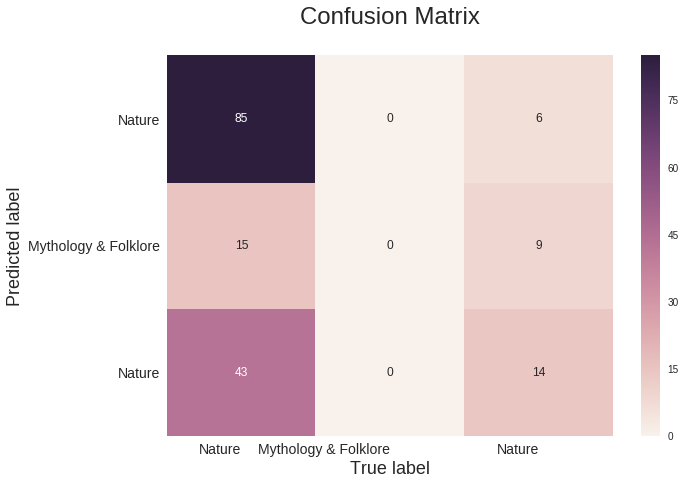

In [18]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [19]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

print(X_train_vec_standardized.shape)
print(epsilon_train.shape)

(401, 52)
(401, 52)


In [20]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon

# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([3.60420459e-08, 1.52042691e-08, 1.22927607e-08, 1.19667102e-08,
       1.18092115e-08, 1.10444874e-08, 1.05743025e-08, 9.91319276e-09,
       9.86109150e-09, 9.11652746e-09, 7.91102975e-09, 7.80629831e-09,
       7.75628286e-09, 7.19728143e-09, 7.08877160e-09, 6.71503607e-09,
       6.71472854e-09, 6.64248790e-09, 5.87375423e-09, 5.67915505e-09])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# RandomizedSearchCV Implementation

In [22]:
# Load libraries
from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l2_random_C = optimal_C
bow_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.08928012502445681, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6104651162790697
The optimal value of C(1/lambda) is :  0.08928012502445681


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

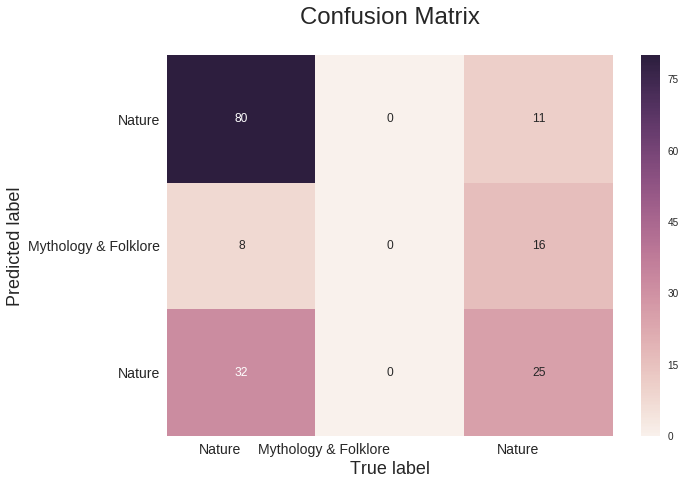

In [23]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [24]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([1.32767568e-05, 9.91066286e-06, 8.47544294e-06, 8.20430112e-06,
       7.29917977e-06, 7.05235058e-06, 6.89800372e-06, 6.81869993e-06,
       6.22160437e-06, 6.13080728e-06, 5.22912627e-06, 4.95795499e-06,
       4.89355584e-06, 4.58841139e-06, 4.40887713e-06, 4.27994979e-06,
       4.11844589e-06, 4.10731051e-06, 3.97073723e-06, 3.80031454e-06])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# (1.b) L1 Regularisation (Logistic regression)

# GridSearchCV Implementation

In [25]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6162790697674418
The optimal value of C(1/lambda) is :  1


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

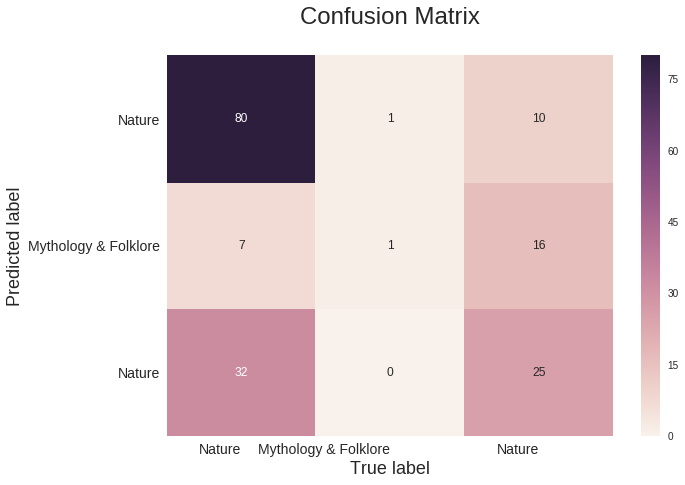

In [26]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [27]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([1.15084167e-04, 6.48798841e-05, 5.97980289e-05, 5.92729694e-05,
       5.42482270e-05, 5.18927813e-05, 4.63948637e-05, 4.27438511e-05,
       4.18153540e-05, 4.14031621e-05, 4.02852078e-05, 3.59460100e-05,
       3.47334186e-05, 3.29451059e-05, 3.28652533e-05, 3.03451145e-05,
       2.73498133e-05, 2.31775379e-05, 2.30683851e-05, 2.25581182e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# RandomizedSearchCV Implementation

In [28]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_random_C = optimal_C
bow_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.5836782637540139, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6162790697674418
The optimal value of C(1/lambda) is :  0.5836782637540139


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

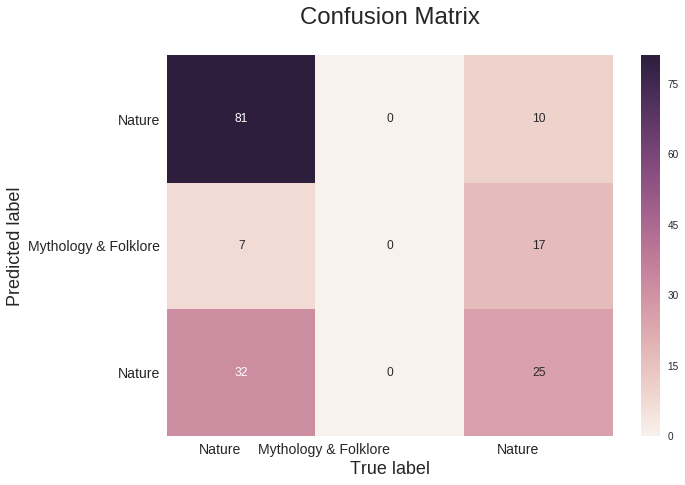

In [30]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [31]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([1.26114479e-04, 7.43713066e-05, 6.61282370e-05, 6.59464199e-05,
       6.34276397e-05, 5.72890277e-05, 4.96736721e-05, 4.54215010e-05,
       4.16769190e-05, 3.96717165e-05, 3.91869691e-05, 3.66145325e-05,
       3.63725751e-05, 3.53444896e-05, 3.50252190e-05, 3.11098676e-05,
       2.43289737e-05, 2.32333184e-05, 2.30844550e-05, 2.11138939e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# (2) TFIDF

In [32]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (401, 52)
the number of unique words : 52


# (2.a) L2 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [0]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l2_grid_C = optimal_C
tfidf_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9245704451625305
The optimal value of C(1/lambda) is :  0.01


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

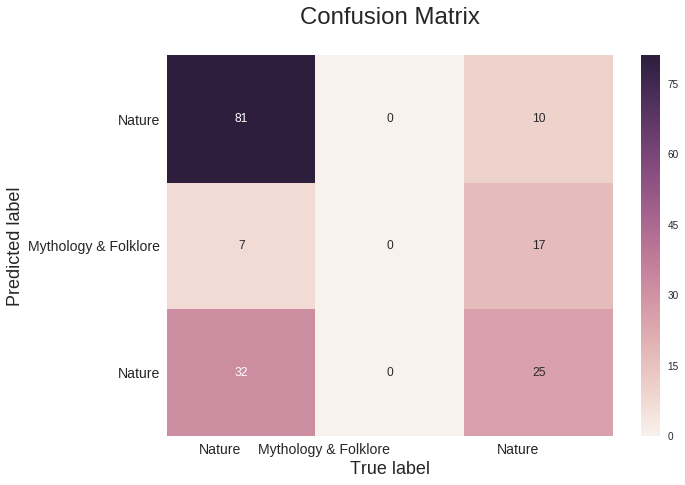

In [33]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [34]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.24679515, 0.20892821, 0.19811854, 0.14739246, 0.14179324,
       0.13583066, 0.1341712 , 0.12520825, 0.11871815, 0.11356387,
       0.11309583, 0.11225459, 0.1003631 , 0.1000637 , 0.09903993,
       0.09725849, 0.08770466, 0.08539864, 0.08272991, 0.08157946])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# RandomizedSearchCV Implementation

In [35]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l2_random_C = optimal_C
tfidf_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.4409278667306049, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6046511627906976
The optimal value of C(1/lambda) is :  0.4409278667306049


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

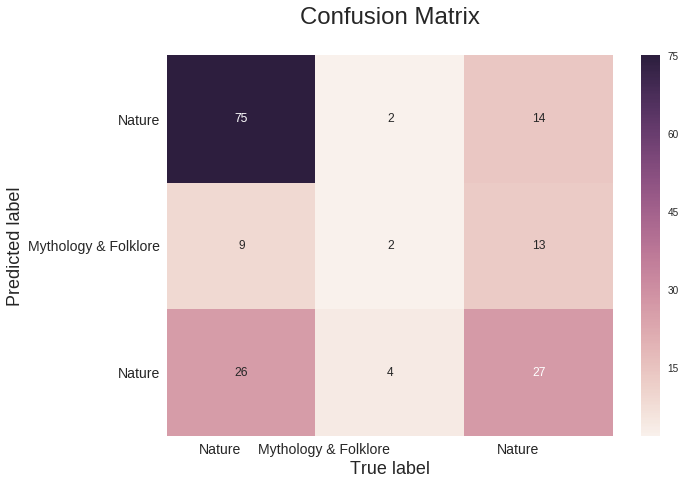

In [37]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [38]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([1.58823910e-05, 1.43294234e-05, 1.40579296e-05, 1.19052718e-05,
       1.05584079e-05, 1.00114277e-05, 9.76786559e-06, 9.57623588e-06,
       9.44646810e-06, 9.37203957e-06, 9.17928218e-06, 9.17553976e-06,
       8.74667380e-06, 8.62592183e-06, 8.57842116e-06, 8.55884860e-06,
       8.51303512e-06, 8.09454638e-06, 7.70208365e-06, 7.05182529e-06])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# (2.b) L1 Regularisation (Logistic regression)

# GridSearchCV Implementation

In [39]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.5290697674418605
The optimal value of C(1/lambda) is :  0.0001


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

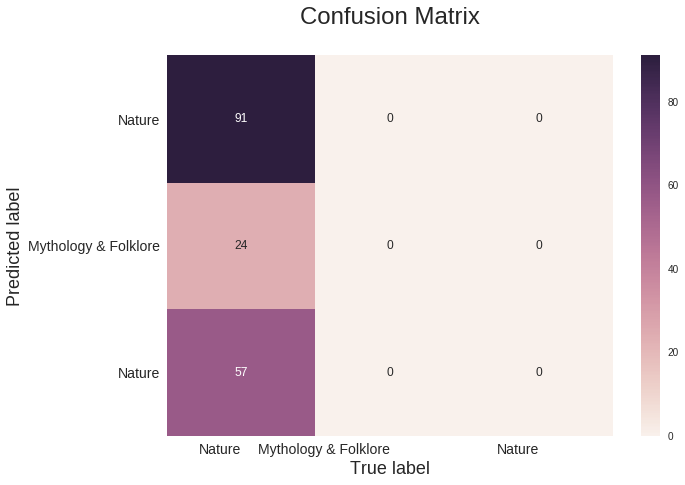

In [40]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [41]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# RandomizedSearchCV Implementation

In [42]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_random_C = optimal_C
tfidf_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.36243600426237643, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6395348837209303
The optimal value of C(1/lambda) is :  0.36243600426237643


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

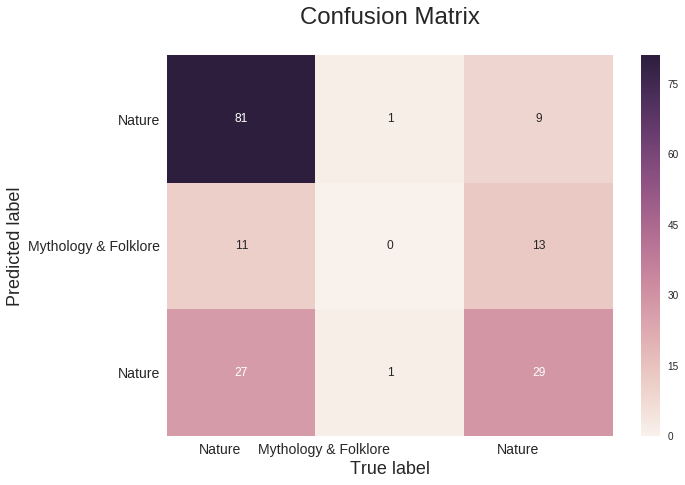

In [43]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [44]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([7.75964915e-05, 6.01170683e-05, 5.77905559e-05, 4.25062044e-05,
       3.79231287e-05, 3.73440834e-05, 3.31444430e-05, 3.25709423e-05,
       3.15905319e-05, 3.07578598e-05, 2.88872399e-05, 2.88060371e-05,
       2.77636911e-05, 2.63824090e-05, 2.49013241e-05, 2.30632039e-05,
       2.20364111e-05, 2.09237677e-05, 1.94799452e-05, 1.77941262e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors .

# Word2Vec

In [45]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  1469


# (3). Avg Word2Vec

In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)    

# (3.a) L2 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [47]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l2_grid_C = optimal_C
avg_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.5872093023255814
The optimal value of C(1/lambda) is :  1


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

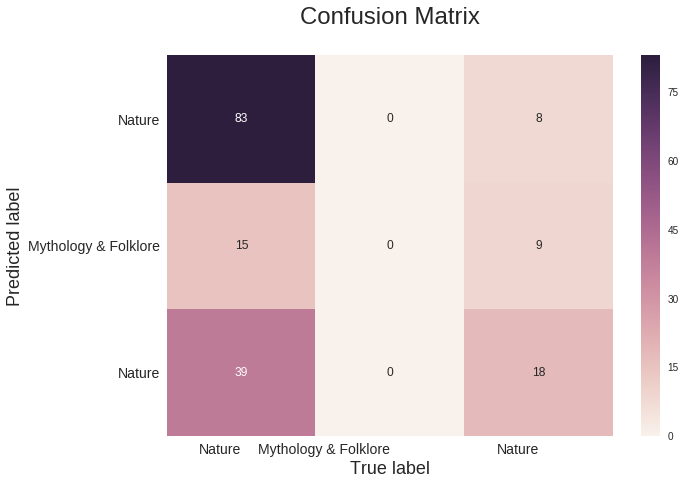

In [48]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation

In [49]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l2_random_C = optimal_C
avg_w2v_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=6.449961639981268, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.622093023255814
The optimal value of C(1/lambda) is :  6.449961639981268


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

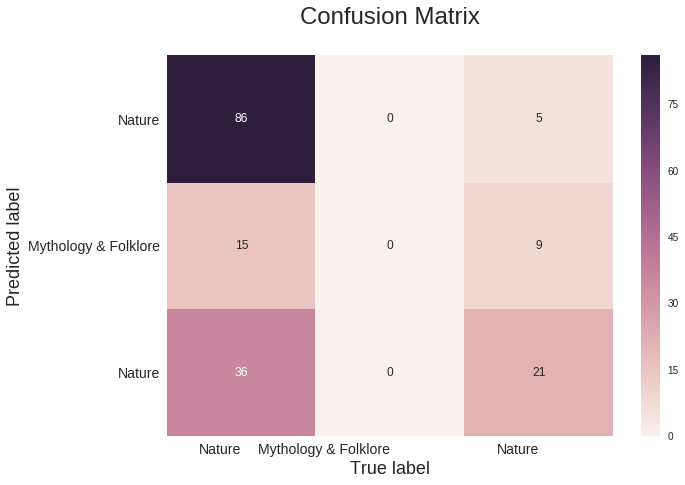

In [50]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (3.b) L1 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [51]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.5813953488372093
The optimal value of C(1/lambda) is :  1


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

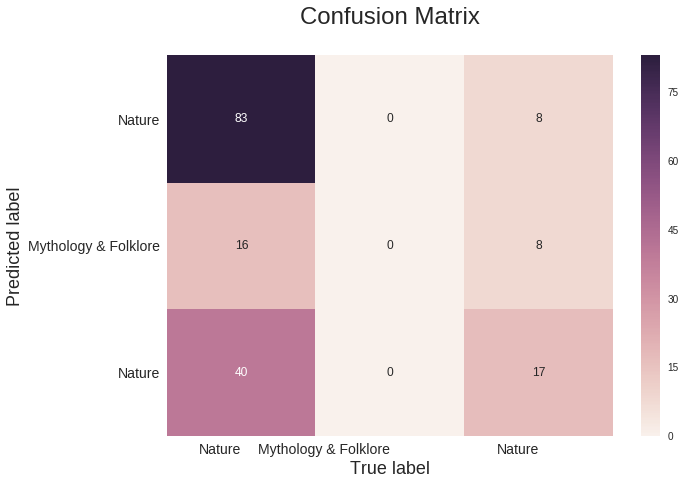

In [52]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation

In [53]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_random_C = optimal_C
avg_w2v_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=6.896529331898334, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.6162790697674418
The optimal value of C(1/lambda) is :  6.896529331898334


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

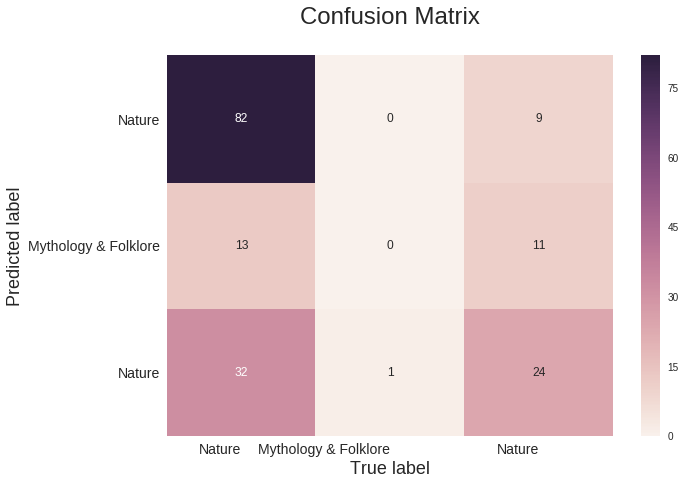

In [54]:
# Code for drawing seaborn heatmaps
class_names = ['Nature','Mythology & Folklore', 'Nature']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION :-

In [0]:
!sudo pip3 install PTable

In [58]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Hyperparameter (c)", "Accuracy"]

x.add_row(["LR(l2|GridSearchCV) for BoW", 0.001, 0.5755813953488372])
x.add_row(["LR(l2|RandomizedSearchCV) for BoW", 0.08928012502445681, 0.6104651162790697])
x.add_row(["LR(l1|GridSearchCV) for BoW", 1, 0.6162790697674418])
x.add_row(["LR(l1|RandomizedSearchCV) for BoW", 0.5836782637540139, 0.6162790697674418])
x.add_row(["LR(l2|GridSearchCV) for TF-IDF", 0.01, 0.9245704451625305])
x.add_row(["LR(l2|RandomizedSearchCV) for TF-IDF", 0.4409278667306049, 0.6046511627906976])
x.add_row(["LR(l1|GridSearchCV) for TF-IDF", 0.0001, 0.5290697674418605])
x.add_row(["LR(l1|RandomizedSearchCV) for TF-IDF", 0.36243600426237643, 0.6395348837209303])
x.add_row(["LR(l2|GridSearchCV) for Avg-w2v", 1, 0.5872093023255814])
x.add_row(["LR(l2|RandomizedSearchCV) for Avg-w2v", 6.449961639981268, 0.622093023255814])
x.add_row(["LR(l1|GridSearchCV) for Avg-w2v", 1, 0.5813953488372093])
x.add_row(["LR(l1|RandomizedSearchCV) for Avg-w2v", 6.896529331898334, 0.6162790697674418])

print(x)

+---------------------------------------+---------------------+--------------------+
|                 Model                 |  Hyperparameter (c) |      Accuracy      |
+---------------------------------------+---------------------+--------------------+
|      LR(l2|GridSearchCV) for BoW      |        0.001        | 0.5755813953488372 |
|   LR(l2|RandomizedSearchCV) for BoW   | 0.08928012502445681 | 0.6104651162790697 |
|      LR(l1|GridSearchCV) for BoW      |          1          | 0.6162790697674418 |
|   LR(l1|RandomizedSearchCV) for BoW   |  0.5836782637540139 | 0.6162790697674418 |
|     LR(l2|GridSearchCV) for TF-IDF    |         0.01        | 0.9245704451625305 |
|  LR(l2|RandomizedSearchCV) for TF-IDF |  0.4409278667306049 | 0.6046511627906976 |
|     LR(l1|GridSearchCV) for TF-IDF    |        0.0001       | 0.5290697674418605 |
|  LR(l1|RandomizedSearchCV) for TF-IDF | 0.36243600426237643 | 0.6395348837209303 |
|    LR(l2|GridSearchCV) for Avg-w2v    |          1          | 0

After the analysis of 573 data points we conclude that the best model is when we apply **LR(l2|GridSearchCV) for TF-IDF** with

**Hyperparameter (c) = 0.01**

**Accuracy = 92.45704451625305%**
